### **Import Dependecies**

In [18]:
import os
import cv2
import random
import numpy as np
import mediapipe as mp
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import TensorBoard

### **Extracting Key Points on Hand Landmarks**

In [3]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [4]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    
    return image, results

In [5]:
# drawing all the hands landmark

def draw_landmarks(image, results):
    # Draw hand connections
    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(
            image, 
            results.left_hand_landmarks, 
            mp_holistic.HAND_CONNECTIONS,
            landmark_drawing_spec=mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
            connection_drawing_spec=mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
        )

    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(
            image, 
            results.right_hand_landmarks, 
            mp_holistic.HAND_CONNECTIONS,
            landmark_drawing_spec=mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
            connection_drawing_spec=mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
        )

In [6]:
# extracting all the landmark keypoints

def extract_keypoints(results):
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    
    return np.concatenate([lh, rh])

### **Preprocess data, create labels, and features**

In [7]:
# Path for exported data, numpy arrays
DATA_PATH = 'DATASET'

# Actions that we try to detect
actions = np.array(['A', 'B', 'C', 'D', 'E', 
                    'F', 'G', 'H', 'I', 'J', 
                    'K', 'L', 'M', 'N', 'O', 
                    'P', 'Q', 'R', 'S', 'T',
                    'U', 'V', 'W', 'X', 'Y', 
                    'Z', 'Halo', 'Perkenalkan', 'Nama',
                    'Saya', 'Senang', 'Bertemu', 'Kamu'])

sequence_length = 30

In [8]:
# Labelling

label_map = {label:num for num, label in enumerate(actions)}
label_map

{'A': 0,
 'B': 1,
 'C': 2,
 'D': 3,
 'E': 4,
 'F': 5,
 'G': 6,
 'H': 7,
 'I': 8,
 'J': 9,
 'K': 10,
 'L': 11,
 'M': 12,
 'N': 13,
 'O': 14,
 'P': 15,
 'Q': 16,
 'R': 17,
 'S': 18,
 'T': 19,
 'U': 20,
 'V': 21,
 'W': 22,
 'X': 23,
 'Y': 24,
 'Z': 25,
 'Halo': 26,
 'Perkenalkan': 27,
 'Nama': 28,
 'Saya': 29,
 'Senang': 30,
 'Bertemu': 31,
 'Kamu': 32}

In [11]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [12]:
np.array(sequences).shape

(1650, 30, 126)

In [13]:
np.array(labels).shape

(1650,)

In [14]:
# Load features di X dan y

X = np.array(sequences)
y = to_categorical(labels).astype(int)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [16]:
print(X_train.shape)
print(X_test.shape)

(1567, 30, 126)
(83, 30, 126)


In [17]:
print(y_train.shape)
print(y_test.shape)

(1567, 33)
(83, 33)


### **Build and train GRU architecture**

In [19]:
# Define the custom callback
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        if (logs.get('accuracy') > 0.98) and (logs.get('val_accuracy') > 0.95):
            print("\nCategorical accuracy is higher than 0.95, stopping training!")
            self.model.stop_training = True

# Instantiate the custom callback
custom_callback = myCallback()

# Set up the TensorBoard callback
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

# Combine both callbacks
callbacks = [custom_callback, tb_callback]

In [22]:
# GRU Arsitektur 

model = Sequential()
model.add(GRU(128, return_sequences=True, activation='relu', input_shape=(30,126)))
model.add(Dropout(0.2))
model.add(GRU(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(actions.shape[0], activation='softmax'))

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, 30, 128)           98304     
                                                                 
 dropout_3 (Dropout)         (None, 30, 128)           0         
                                                                 
 gru_3 (GRU)                 (None, 64)                37248     
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_5 (Dropout)         (None, 32)               

In [24]:
model.compile(optimizer='Adam', 
            loss='categorical_crossentropy', 
            metrics=['accuracy'])

In [25]:
gru_history = model.fit(X_train, y_train, 
                        validation_data=(X_test, y_test), 
                        epochs=1200, 
                        callbacks=[callbacks])

Epoch 1/1200
49/49 [==============================] - 11s 61ms/step - loss: 4.2766 - accuracy: 0.0325 - val_loss: 3.9981 - val_accuracy: 0.1446
Epoch 2/1200
49/49 [==============================] - 2s 48ms/step - loss: 3.7736 - accuracy: 0.0657 - val_loss: 3.3643 - val_accuracy: 0.1446
Epoch 3/1200
49/49 [==============================] - 2s 48ms/step - loss: 3.2606 - accuracy: 0.1193 - val_loss: 2.8652 - val_accuracy: 0.1928
Epoch 4/1200
49/49 [==============================] - 3s 56ms/step - loss: 2.9604 - accuracy: 0.1481 - val_loss: 2.7274 - val_accuracy: 0.1807
Epoch 5/1200
49/49 [==============================] - 2s 43ms/step - loss: 2.7226 - accuracy: 0.1761 - val_loss: 2.5257 - val_accuracy: 0.2771
Epoch 6/1200
49/49 [==============================] - 2s 41ms/step - loss: 2.5097 - accuracy: 0.2304 - val_loss: 2.2606 - val_accuracy: 0.3253
Epoch 7/1200
49/49 [==============================] - 2s 43ms/step - loss: 2.2809 - accuracy: 0.2706 - val_loss: 2.0389 - val_accuracy: 0.373

In [29]:
model.save('33Class_GRU_acc098_loss01_50seq.h5')

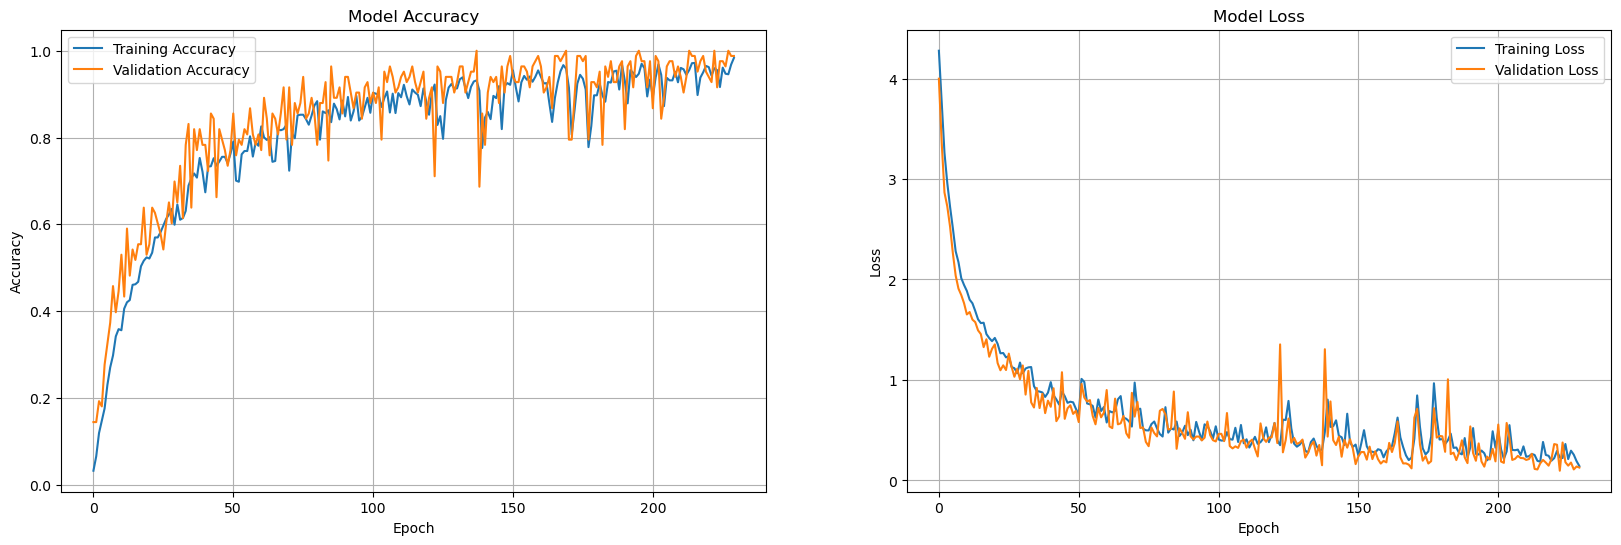

In [26]:
# Assuming training_history is the variable holding the history after training
history = gru_history.history

# Extract accuracy, validation accuracy, loss, and validation loss
accuracy = history['accuracy']
val_accuracy = history['val_accuracy']
loss = history['loss']
val_loss = history['val_loss']

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot accuracy
ax1.plot(accuracy, label='Training Accuracy')
ax1.plot(val_accuracy, label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='upper left')
ax1.grid(True)

# Plot loss
ax2.plot(loss, label='Training Loss')
ax2.plot(val_loss, label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')
ax2.grid(True)

plt.show()


3/3 [==============================] - 0s 18ms/step


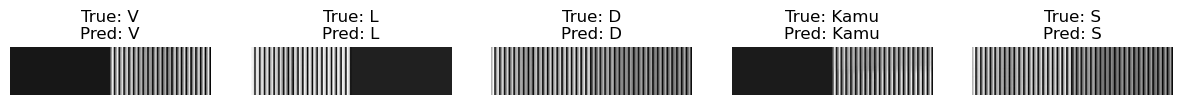

In [28]:
# Generate predictions on the test set
y_pred = model.predict(X_test)

# Convert predictions and true labels from one-hot encoding to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Visualize sample predictions
num_samples = 5
sample_indices = random.sample(range(len(X_test)), num_samples)

plt.figure(figsize=(15, 10))
for i, idx in enumerate(sample_indices):
    plt.subplot(1, num_samples, i+1)
    # Assuming the first frame from the sequence for visualization
    frame = X_test[idx][:, :].reshape((30, 126))  # Reshape for visualization
    
    # Display the first frame of the sequence
    plt.imshow(frame, cmap='gray')
    plt.title(f"True: {actions[y_true_classes[idx]]}\nPred: {actions[y_pred_classes[idx]]}")
    plt.axis('off')

plt.show()